# Pipeline Verification Report
This notebook provides an interactive and visual verification of the ClickHouse pipeline against the Python baseline.
It performs the following steps:
1. **Ingest Data**: Loads `multi_maids_sample.csv` into ClickHouse.
2. **Execute View**: Queries the `view_aggregated_data` for each MAID.
3. **Compare**: Validates ClickHouse results against reference JSONs (`aggregated_data_100.json`).
4. **Visualize**: Plots score correlations and error distributions.


In [1]:

import pandas as pd
import json
import subprocess
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configure plotting
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:

def run_query(query):
    cmd = ['docker', 'exec', 'clickhouse-server', 'clickhouse-client', '--format', 'JSON', '--query', query]
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Query Error: {result.stderr}")
        return None
    try:
        return json.loads(result.stdout)
    except json.JSONDecodeError:
        return result.stdout

def run_command_no_output(query):
    cmd = ['docker', 'exec', 'clickhouse-server', 'clickhouse-client', '--query', query]
    subprocess.run(cmd, check=True)


## 1. Data Ingestion
Reloads data from CSV to ensure a fresh state.

In [3]:

# Clean and Clean
print("Cleaning tables...")
run_command_no_output("TRUNCATE TABLE IF EXISTS raw_maid_pings")

print("Importing multi_maids_sample.csv...")
df = pd.read_csv('multi_maids_sample.csv')
if 'geohash' in df.columns:
    df = df.drop(columns=['geohash'])
df['timestamp'] = df['timestamp'].astype(str).str.split('+').str[0]

csv_buffer = io.BytesIO()
df.to_csv(csv_buffer, index=False)
csv_buffer.seek(0)

cmd_insert = [
    'docker', 'exec', '-i', 'clickhouse-server', 
    'clickhouse-client', 
    '--query', 'INSERT INTO raw_maid_pings (maid,timestamp,latitude,longitude,flux) FORMAT CSVWithNames'
]
proc = subprocess.Popen(cmd_insert, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = proc.communicate(input=csv_buffer.getvalue())

if proc.returncode == 0:
    print("✅ Insert Successful.")
    run_command_no_output("OPTIMIZE TABLE raw_maid_pings FINAL")
else:
    print(f"❌ Insert Failed: {err.decode()}")


Cleaning tables...
Importing multi_maids_sample.csv...
✅ Insert Successful.


## 2. Verification Loop
Iterates through all MAIDs and compares scores.

In [4]:

# Load Expectations
with open('aggregated_data_100.json', 'r') as f:
    multi_agg_json = json.load(f)

print(f"Verifying {len(multi_agg_json)} MAIDs...")

results = []

for maid, agg_json in multi_agg_json.items():
    # Query ClickHouse
    view_data = run_query(f"SELECT * FROM view_aggregated_data WHERE maid = '{maid}'")
    
    if not view_data or not view_data.get('data'):
        results.append({'maid': maid, 'status': 'MISSING', 'error': 'No Data'})
        continue
        
    v_row = view_data['data'][0]
    
    # Extract lists
    ch_geohashes = v_row['geohash']
    ch_home = v_row['home_score']
    ch_work = v_row['work_score']
    
    ch_map = {gh: {'h': h, 'w': w} for gh, h, w in zip(ch_geohashes, ch_home, ch_work)}
    
    # Extract JSON Reference
    ref_geohashes = agg_json['geohash']
    ref_home = agg_json['home_score']
    ref_work = agg_json['work_score']
    
    ref_map = {gh: {'h': h, 'w': w} for gh, h, w in zip(ref_geohashes, ref_home, ref_work)}
    
    # Compare per geohash
    for gh, ref_scores in ref_map.items():
        if gh not in ch_map:
            continue # Should log missing geohash
            
        ch_scores = ch_map[gh]
        
        diff_h = abs(ref_scores['h'] - ch_scores['h'])
        diff_w = abs(ref_scores['w'] - ch_scores['w'])
        
        status = 'PASS' if diff_h < 0.1 and diff_w < 0.1 else 'FAIL'
        
        results.append({
            'maid': maid,
            'geohash': gh,
            'ref_home': ref_scores['h'],
            'ch_home': ch_scores['h'],
            'diff_home': diff_h,
            'ref_work': ref_scores['w'],
            'ch_work': ch_scores['w'],
            'diff_work': diff_w,
            'status': status
        })

df_res = pd.DataFrame(results)
print(f"Processed {len(df_res)} geohash comparisons.")


Verifying 100 MAIDs...
Processed 30852 geohash comparisons.


## 3. Analysis & Visualization

--- PASS/FAIL Summary ---
status
PASS    20545
FAIL    10307
Name: count, dtype: int64

--- Top Failures ---


,maid,geohash,ref_home,ch_home,diff_home,ref_work,ch_work,diff_work,status
19884,ad9j9JKzMKgRQUyxHg+dGQBZamd2Cftae8yOscqFvAiMFT...,w21z6bf,0.048509,0.393559,0.345050,0.340923,0.401323,0.060400,FAIL
19808,ad9j9JKzMKgRQUyxHg+dGQBZamd2Cftae8yOscqFvAiMFT...,rck7w4j,0.087880,0.432902,0.345021,0.240520,0.305005,0.064486,FAIL
6158,8hMTM6j7mgoIhaCsezexqzHYr3BjpVyDjGlz6AHYuJt5fh...,spfb071,0.102195,0.430486,0.328291,0.031594,0.053245,0.021651,FAIL
26497,oAUInjLmem+iu8VSfURGl1utjCDLrlJe4+/SqId1Re3dBI...,ev3tq4v,0.058530,0.386028,0.327498,0.116261,0.150749,0.034488,FAIL
6244,8hMTM6j7mgoIhaCsezexqzHYr3BjpVyDjGlz6AHYuJt5fh...,u09tvmy,0.112690,0.434487,0.321797,0.125500,0.153535,0.028034,FAIL


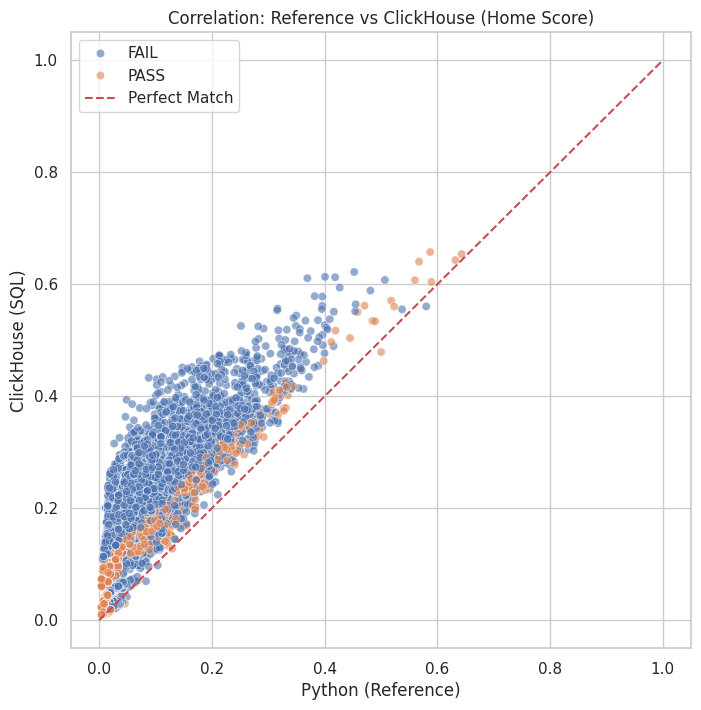

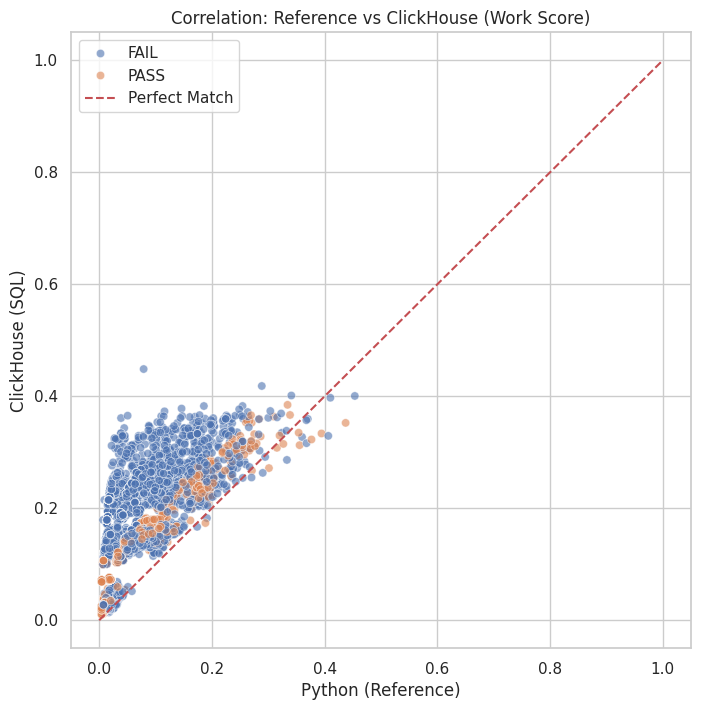

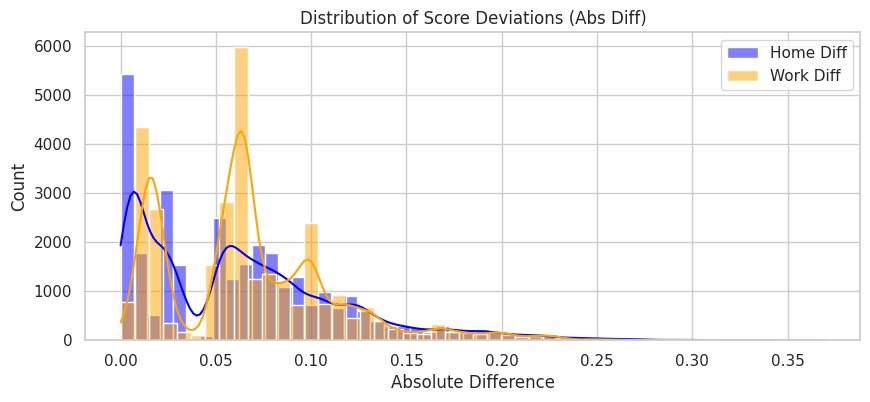

In [5]:

# Summary
print("--- PASS/FAIL Summary ---")
print(df_res['status'].value_counts())

# Failures
failures = df_res[df_res['status'] == 'FAIL']
if not failures.empty:
    print("\n--- Top Failures ---")
    display(failures.sort_values(by='diff_home', ascending=False).head(5))
else:
    print("\n✅ No significant failures found!")

# Visualization: Scatter Plot of Home Scores
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_res, x='ref_home', y='ch_home', hue='status', alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Match')
plt.title('Correlation: Reference vs ClickHouse (Home Score)')
plt.xlabel('Python (Reference)')
plt.ylabel('ClickHouse (SQL)')
plt.legend()
plt.show()

# Visualization: Scatter Plot of Work Scores
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_res, x='ref_work', y='ch_work', hue='status', alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Match')
plt.title('Correlation: Reference vs ClickHouse (Work Score)')
plt.xlabel('Python (Reference)')
plt.ylabel('ClickHouse (SQL)')
plt.legend()
plt.show()

# Distribution of Differences
plt.figure(figsize=(10, 4))
sns.histplot(df_res['diff_home'], bins=50, kde=True, color='blue', label='Home Diff')
sns.histplot(df_res['diff_work'], bins=50, kde=True, color='orange', label='Work Diff')
plt.title('Distribution of Score Deviations (Abs Diff)')
plt.xlabel('Absolute Difference')
plt.legend()
plt.show()


Fetching score data from ClickHouse...
Fetched 30852 records.


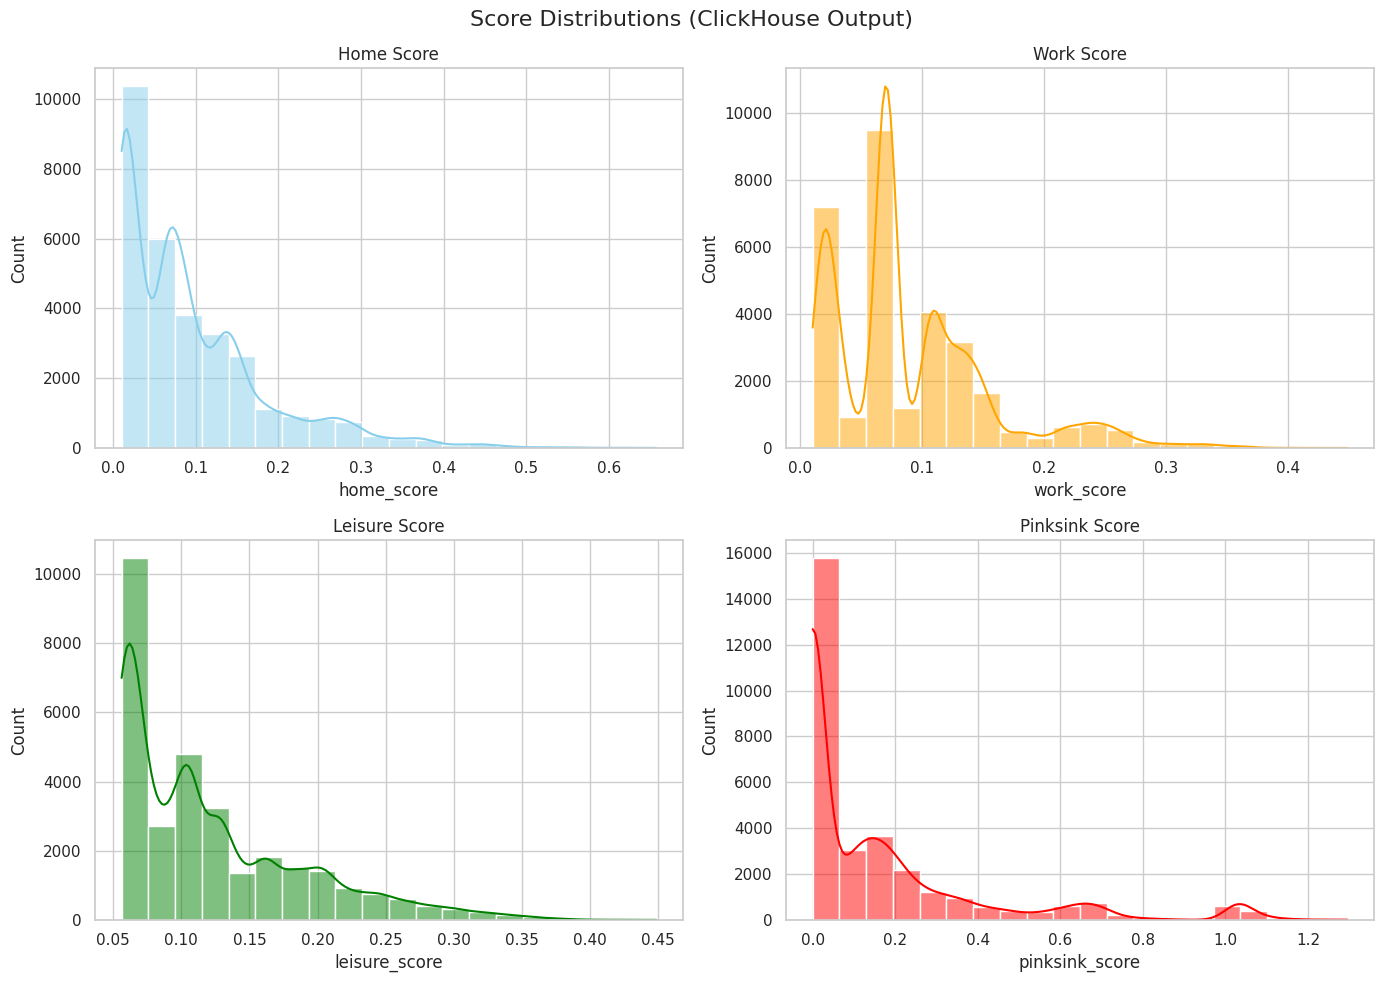

In [6]:

# 4. Visualizing Score Distributions
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distributions():
    print('Fetching score data from ClickHouse...')
    query = """
    SELECT 
        geohash, 
        home_score, 
        work_score, 
        leisure_score, 
        pingsink_score
    FROM view_aggregated_data 
    ARRAY JOIN geohash, home_score, work_score, leisure_score, pingsink_score
    """
    
    # Re-use run_query from previous cells or redefine if needed
    # Assuming run_query is available in notebook state
    data = run_query(query)
    if not data or 'data' not in data:
        print('No data fetched.')
        return

    df_scores = pd.DataFrame(data['data'])
    print(f'Fetched {len(df_scores)} records.')
    
    score_cols = ['home_score', 'work_score', 'leisure_score', 'pingsink_score']
    for col in score_cols:
        df_scores[col] = pd.to_numeric(df_scores[col], errors='coerce')

    sns.set_theme(style='whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Score Distributions (ClickHouse Output)', fontsize=16)

    sns.histplot(df_scores['home_score'], bins=20, kde=True, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Home Score')

    sns.histplot(df_scores['work_score'], bins=20, kde=True, ax=axes[0, 1], color='orange')
    axes[0, 1].set_title('Work Score')

    sns.histplot(df_scores['leisure_score'], bins=20, kde=True, ax=axes[1, 0], color='green')
    axes[1, 0].set_title('Leisure Score')

    sns.histplot(df_scores['pingsink_score'], bins=20, kde=True, ax=axes[1, 1], color='red')
    axes[1, 1].set_title('Pingsink Score')

    plt.tight_layout()
    plt.show()

plot_distributions()
